<font size="5">**TP Earth Observation: Implement a non-linear NN regression to substitute the linear regression of TsHARP**<font>
    
<font size="3">**Author: C. Granero Belinchon**<font>

<font size="3">**Date: 17th april 2023**<font>


Detailed information on these super-resolution methods can be found in Granero-Belinchon, C.; Michel, A.; Lagouarde, J.-P.; Sobrino, J.A.; Briottet, X. Multi-Resolution Stufrom osgeo import gdal
import numpy as np
import matplotlib.pyplot as pltdy of Thermal Unmixing Techniques over Madrid Urban Area: Case Study of TRISHNA Mission. Remote Sens. 2019, 11, 1251. https://doi.org/10.3390/rs11101251 

In [6]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset

<font size="3">**1. Non-linear NN regressor**<font>

We start by loading the needed data, i.e. a) coarse resolution LST, coarse resolution VNIR-SWIR index and high resolution VNIR-SWIR index

In [17]:
path_index_h = "data/NDBI_20m.img"
path_index_c = "data/NDBI_100m.img"
path_temperature_c = "data/LST_100m.img"

################### Index H ##########################################

with rasterio.open(path_index_h) as dataset:
    I_H = dataset.read(1).astype(np.float32) 
    cols = dataset.width
    rows = dataset.height

################### Temperature C ######################################

with rasterio.open(path_temperature_c) as dataset:
    T_C = dataset.read(1).astype(np.float32)
    cols_temp = dataset.width
    rows_temp = dataset.height

################### Index C ##########################################

with rasterio.open(path_index_c) as dataset:
    I_C = dataset.read(1).astype(np.float32)
    cols_c = dataset.width
    rows_c = dataset.height

    ################### Geographic data ##########################################
    projection_C = dataset.crs
    geotransform_C = dataset.transform

In [19]:
T_C

array([[321.29984, 320.43875, 321.4949 , 320.41483, 321.75073, 321.24478,
        319.01288, 318.3169 , 320.24457, 320.37512, 322.1456 , 324.91315,
        324.8657 , 328.3993 , 329.55338, 324.32574, 322.32376, 322.0079 ,
        322.82495, 317.69916, 323.28534, 323.08588, 321.19864, 321.30597,
        321.7851 , 323.87683, 321.87988, 317.06042, 317.78748, 317.52026],
       [320.14642, 317.74042, 317.77667, 316.80353, 318.11072, 319.04858,
        317.94824, 318.8405 , 320.37582, 319.00433, 320.48898, 323.84256,
        324.73657, 325.49988, 325.06668, 323.21344, 323.74097, 321.94202,
        324.54718, 319.88507, 320.14664, 322.78296, 322.63177, 321.37512,
        321.5267 , 323.4166 , 323.36588, 319.7769 , 317.58423, 316.52594],
       [319.12045, 315.38397, 315.4652 , 315.5453 , 315.5904 , 318.12207,
        318.78635, 320.4808 , 322.16977, 322.42276, 322.4999 , 324.16415,
        324.7105 , 325.67307, 324.6805 , 324.636  , 322.72852, 322.55212,
        324.92078, 321.75198, 319.75

We format the data

In [8]:
# Normalization
sIc=np.std(I_C)
sTc=np.std(T_C)
mIc=np.mean(I_C)
mTc=np.mean(T_C)
I_C=(I_C-np.mean(I_C))/np.std(I_C)
T_C=(T_C-np.mean(T_C))/np.std(T_C)

#Create dataloader
signals_all = np.stack((I_C.flatten(), T_C.flatten()),axis=1)
signals_all = signals_all[:,:,np.newaxis]

class TrajDataSet(Dataset):
    def __init__(self,  traj, transform=None):
        self.traj = traj
        self.transform = transform

    def __len__(self):
        return self.traj.shape[0]

    def __getitem__(self, idx):
        # select coordinates
        sample = self.traj[idx,:,:]
        if self.transform:
            sample = self.transform(sample)

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        if(cuda):
            return torch.FloatTensor(sample).cuda()
        else:
            return torch.FloatTensor(sample)
        #return torch.FloatTensor(sample)

# hyperparameters
batch_size = 128
batches=signals_all.shape[0]/batch_size

## reduce size dataset
train_set = TrajDataSet(signals_all, transform= ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

#x =  next(iter(train_loader))
#x = x.cpu().numpy()

<font size="2">**Fit**<font>
    
Define a NN non-linear fit

In [9]:
from torch import nn
from torch import optim

cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Sequential( 
            nn.Linear(1, 256, bias = False),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            )
        self.lin2 = nn.Sequential(
            nn.Linear(256, 512, bias = False),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            )
        self.lin3 = nn.Sequential(
            nn.Linear(512, 1, bias = False),
            nn.BatchNorm1d(1),
            )
        
    def forward(self, z):    
        out  = self.lin1(z)
        out  = self.lin2(out)
        out  = self.lin3(out)
        return out

Network and optimizer initialization

In [10]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# create network
reg = Regressor().to(dev)

# weight initialization
reg = reg.apply(weights_init)

# define loss and optimizers
criterion = nn.MSELoss().to(dev)
lr = 0.02
optim_reg = optim.Adam(reg.parameters(),lr= lr, betas=(0.5, 0.999))

#print("Model  ", next(reg.parameters()).is_cuda)

Training loops

In [11]:
# Train the model
nb_epoch = 100
# Initialize
cout=torch.zeros((nb_epoch), device=dev)

#torch.autograd.set_detect_anomaly(True)
epoch = 0
for i in range(nb_epoch):
    epoch +=1

    for batch, x in enumerate(train_loader):
        
        reg.zero_grad()
        
        generated = reg(x[:,0])
        loss = criterion(generated, x[:,1])
        loss.backward()
        optim_reg.step()
        ll=+loss

    cout[i]=ll/batches

    if cout[i]<0.01:
        print('\nEpoch [{}/{}] -----------------------------------------------------------------------------'.format(epoch+1, nb_epoch))

        PATH='./Model_epoch_'+str(epoch)+'.pt'
        torch.save({
            #'epoch': epoch,
            'model_state_dict': reg.state_dict(),
            #'optimizer_state_dict': optim_g.state_dict(),
            #'loss': loss,
            }, PATH)


cout = cout.cpu().detach().numpy()
np.savez('./Loss_Model.npz',cout=cout)


Epoch [15/100] -----------------------------------------------------------------------------

Epoch [52/100] -----------------------------------------------------------------------------

Epoch [74/100] -----------------------------------------------------------------------------

Epoch [85/100] -----------------------------------------------------------------------------


Plot the Loss function and choose the best epoch

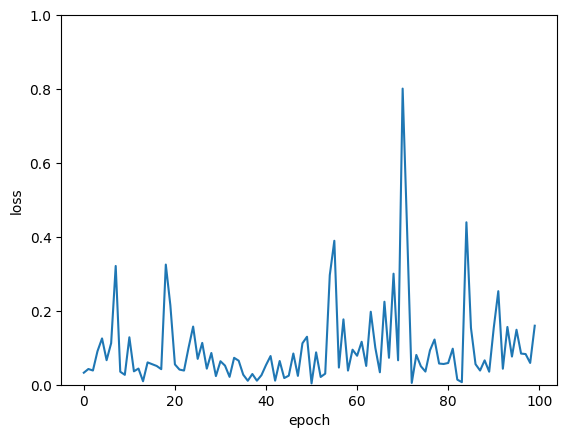

In [12]:
plt.figure()
plt.plot(cout)
plt.ylabel("loss")
plt.xlabel('epoch')
plt.ylim(0,1)
plt.show()

Plot the LST in function of the VI and the obtained non-linear regression in the same figure

In [13]:
PATH='./Model_epoch_26.pt'

checkpoint = torch.load(PATH,map_location=torch.device('cpu'))

reg = Regressor()
reg.load_state_dict(checkpoint['model_state_dict'])
reg.eval()

I_C_cuda=torch.from_numpy(I_C.flatten()[:,np.newaxis]).double()
reg=reg.double()

T_C_reg=reg(I_C_cuda)

T_C_reg=T_C_reg.detach().numpy().reshape(T_C.shape[0],T_C.shape[1])
#I=I_C_cuda.detach().numpy()*sIc + mIc

plt.plot(I_C*sIc + mIc,T_C_reg*sTc + mTc,'k.')
plt.scatter(I_C*sIc + mIc,T_C*sTc + mTc,s=1,c='blue')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './Model_epoch_26.pt'

<font size="2">**Sharpening**<font>
    
Generate a first estimate of the LST image at fine resolution. To do this define a function linear_sharpening

In [14]:
sIh=np.std(I_H)
mIh=np.mean(I_H)
I_H=(I_H-np.mean(I_H))/np.std(I_H)

I_H_cuda=torch.from_numpy(I_H.flatten()[:,np.newaxis]).double()
reg=reg.double()

T_h_reg=reg(I_H_cuda)

T_sharp_temp=T_h_reg.detach().numpy()*sTc + mTc

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

Plot this first estimate of LST map

In [ ]:
import matplotlib.pyplot as plt

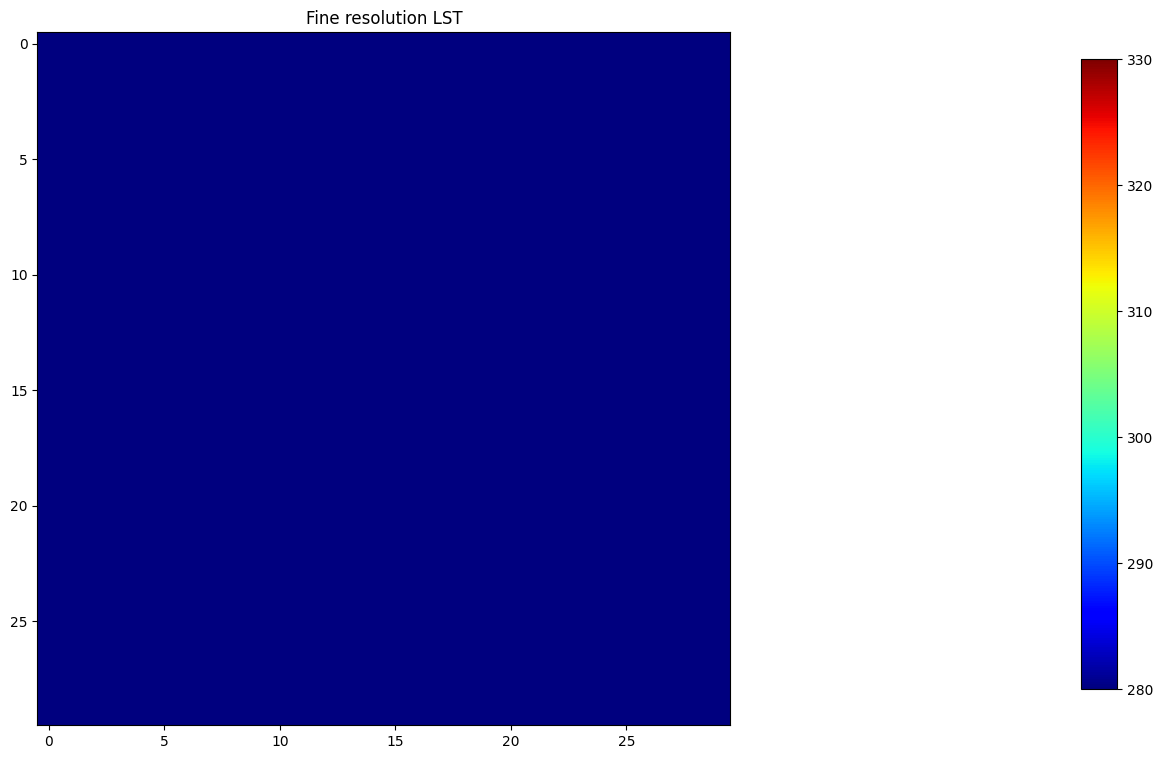

In [16]:
# T_sharp_temp = T_sharp_temp.reshape((I_H.shape[0], I_H.shape[1]))

fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=False, figsize=(18, 9))

ax0.set_title('Fine resolution LST')
img=ax0.imshow(I_C, vmin=280, vmax=330, cmap='jet')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()

<font size="2">**Residual Correction**<font>
    
Generate a final LST estimation by performing a residual correction on the precedent one. Write a function correction_linreg that provides the residual correction Delta_T_final

In [108]:
import cv2

def correction_linreg(Temp, Treg, iscale):
    
    
    '''
    This function takes two images (path_index, path_temperature) and 
    computes the residuals of each coarse and fine pixel. For the coarse pixels 
    it computes the residuals as the difference between the measured coarse 
    temperature of the pixel and the coarse temperature obtained with the linear regression 
    $R_coarse=T_measured_coarse - (a1*I_measured_coarse + a0)$. Then the residuals for each 
    fine pixel resolution inside a coarse pixel is the residual of the coarse 
    pixel (scale invariance hypothesis).
    
    ############## Inputs:
        
    index (large scale): reflective index image, ex: NDVI, NDBI ...
             
    Temp (large scale): Temperature image. the background pixels must be == 0
            
    iscale: size factor between measured pixel and unmixed pixel. 
             Ex: if the initial resolution of Temp is 90m and the resolution 
                 after unmixing is 10m iscale=9. 
    
    fit_param: fit parameters used to retrieve LST from index
           
    '''

    (rows,cols)=Temp.shape
    
    #  We define the delta at the scale of the measured temperature as in the model.
    Delta_T = Temp - Treg.reshape(Temp.shape[0],Temp.shape[1])
    
    # We obtain the delta at the scale of the unmixed temperature
    Delta_T_final = cv2.resize(Delta_T, (Temp.shape[0]*iscale, Temp.shape[1]*iscale), 0, 0, interpolation = cv2.INTER_NEAREST)
    
    #Delta_T_final =np.zeros((rows,cols))
    #for ic in range(int(np.floor(cols/iscale))):
    #    for ir in range(int(np.floor(rows/iscale))):
    #        for ir_2 in range(ir*iscale,(ir*iscale+iscale)):
    #            for ic_2 in range(ic*iscale,(ic*iscale+iscale)):
    #                if mask_TT_unm[ir_2,ic_2]==0:
    #                    Delta_T_final[ir_2,ic_2] = 0
    #                else:
    #                    Delta_T_final[ir_2,ic_2] = Delta_T[ir,ic]

    return Delta_T_final

Plot together the coarse LST and the final fine scale LST

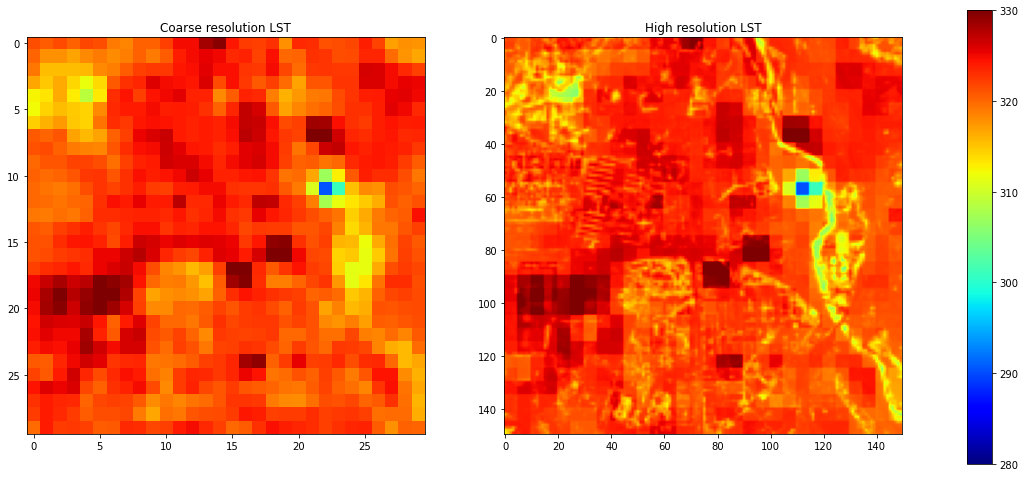

In [109]:
iscale=5

DeltaT=correction_linreg(T_C*sTc + mTc, T_C_reg*sTc + mTc, iscale)

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(18, 9))

ax0.set_title('Coarse resolution LST')
ax0.imshow(T_C*sTc + mTc, vmin=280, vmax=330, cmap='jet')

ax1.set_title('High resolution LST')
img=ax1.imshow(T_sharp_temp+DeltaT, vmin=280, vmax=330, cmap='jet')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()

Load the ground truth LST and compare it to the coarse scale LST the non corrected fine scale LST and the final product.

In [110]:
path_temperature_h = 'Images/LST_20m.img'

################### Temperature H ######################################
    
# Reading temperature data
filename = path_temperature_h
dataset = gdal.Open(filename)
cols = dataset.RasterXSize #Spatial dimension x
rows = dataset.RasterYSize #Spatial dimension y
    
# Read as array
T_H= dataset.ReadAsArray(0, 0, cols, rows).astype(np.float)

# We can compute for example the RMSE
RMSE_GT_Final = np.mean(((T_sharp_temp+DeltaT) - T_H)**2)
RMSE_GT_NC = np.mean(((T_sharp_temp) - T_H)**2)
RMSE_GT_C = np.mean((cv2.resize(T_C*sTc + mTc, (T_C.shape[0]*iscale, T_C.shape[1]*iscale), 0, 0, interpolation = cv2.INTER_NEAREST)-T_H)**2)

print('RMSE with coarse scale', RMSE_GT_C)
print('RMSE with non corrected', RMSE_GT_NC)
print('RMSE with final product', RMSE_GT_Final)

RMSE with coarse scale 13.623012873766365
RMSE with non corrected 21.744614978205004
RMSE with final product 10.474316305199917


/tmp/ipykernel_16903/3922170800.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  T_H= dataset.ReadAsArray(0, 0, cols, rows).astype(np.float)


Plot the sharpened fine scale LST in function of the fine scale VI and the corresponding linear regression. Plot also the true fine scale LST in function of the fine scale VI.

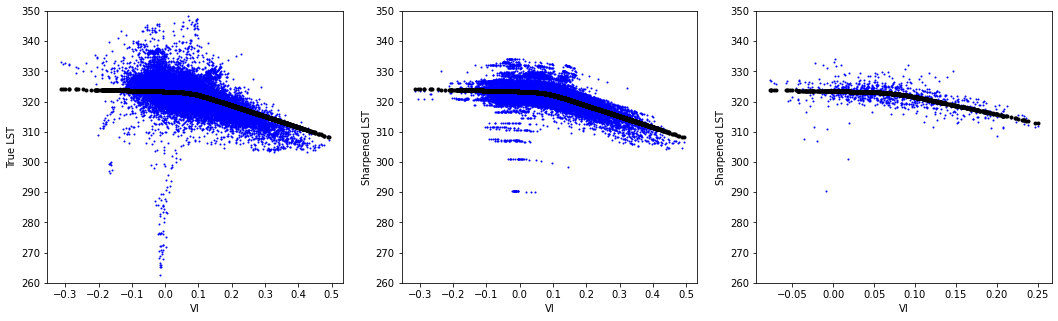

In [111]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=False, figsize=(18, 5))

#ax0.set_title('Coarse resolution LST')
ax0.scatter(I_H*sIh+mIh,T_H,s=1,c='blue')
ax0.plot(I_H*sIh+mIh,T_sharp_temp,'.k')
ax0.set_xlabel('VI')
ax0.set_ylabel('True LST')
ax0.set_ylim((260,350))

#ax1.set_title('High resolution LST')
ax1.scatter(I_H*sIh+mIh,T_sharp_temp+DeltaT,s=1,c='blue')
ax1.plot(I_H*sIh+mIh,T_sharp_temp,'.k')
ax1.set_xlabel('VI')
ax1.set_ylabel('Sharpened LST')
ax1.set_ylim((260,350))

ax2.scatter(I_C*sIc + mIc,T_C*sTc + mTc,s=1,c='blue')
ax2.plot(I_C*sIc + mIc,T_C_reg*sTc + mTc,'.k')
ax2.set_xlabel('VI')
ax2.set_ylabel('Sharpened LST')
ax2.set_ylim((260,350))
#fig.subplots_adjust(right=0.8)
#cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
#cbar=fig.colorbar(img, cax=cbar_ax)

plt.show()